<a href="https://colab.research.google.com/github/smccracken13/Zestimate-Project/blob/main/Zestimate_Data_Wrangling_(McCracken).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Zestimate Data Wrangling
https://www.kaggle.com/competitions/zillow-prize-1

Scott McCracken

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Load the data sets from Kaggle
There is data from two home selling seasons: 2016 and 2017. Each season has a train.csv that includes transaction dates and log error (the error that the Zestimate had) and a properties.csv that contains home features. Eventually, we will need to predict logerror.

# File descriptions
prop16 - all the properties with their home features for 2016.

train16 - the training set with transactions from 1/1/2016 to 12/31/2016

sample_submission.csv - a sample submission file in the correct format

In [2]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"getitcracken","key":"1738535d0942e470367a3e2f5eab5c24"}'}

In [3]:
# I will load the datasets directly from Kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# prop16 contains property features for most of 2016
!kaggle competitions download -c zillow-prize-1 -f properties_2016.csv
!unzip properties_2016.csv.zip
prop16 = pd.read_csv('properties_2016.csv', low_memory=False)

properties_2016.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  properties_2016.csv.zip
replace properties_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
# train16 contains parcel_id, transaction dates, and logerror for most of 2016
!kaggle competitions download -c zillow-prize-1 -f train_2016_v2.csv
!unzip train_2016_v2.csv.zip
train16 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)

train_2016_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_2016_v2.csv.zip
replace train_2016_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Shape of each dataframe

In [6]:
print("Prop16 shape:", prop16.shape)
print("Train16 shape:", train16.shape)

Prop16 shape: (2985217, 58)
Train16 shape: (90275, 3)


# Peek at train16

In [7]:
train16.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [8]:
print('Non unique parcelid rows for 2016:', 90275 - train16['parcelid'].nunique())
(train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

Non unique parcelid rows for 2016: 125


1    90026
2      123
3        1
Name: parcelid, dtype: int64

In [9]:
# First and last tranaction dates
print("First Transaction 2016:", train16['transactiondate'].min())
print("Last Transaction 2016:", train16['transactiondate'].max())

First Transaction 2016: 2016-01-01 00:00:00
Last Transaction 2016: 2016-12-30 00:00:00


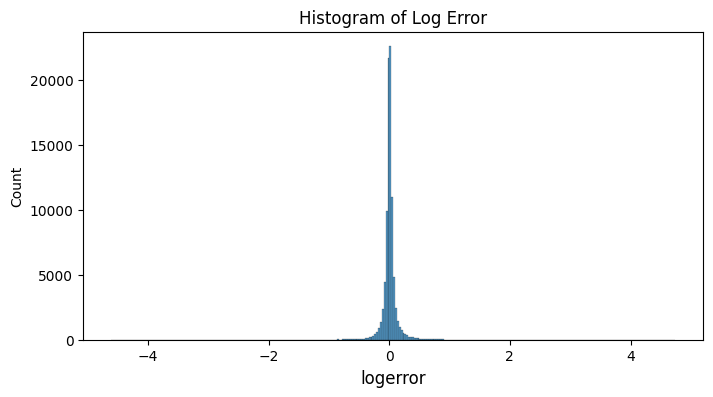

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(train16.logerror.values, bins=300, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.title('Histogram of Log Error')
plt.show()

In [11]:
print("Worst negative logerror:", train16['logerror'].min())
print("Worst positive logerror:", train16['logerror'].max())

Worst negative logerror: -4.605
Worst positive logerror: 4.737


Check for null in transaction data

In [12]:
missing = pd.concat([train16.isnull().sum(), 100 * train16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
parcelid,0,0.0
logerror,0,0.0
transactiondate,0,0.0


# Prep datetime data for modeling

In [13]:
# All dates are from 2016, let's extract month, day, and quarter
train16["transaction_month"] = train16["transactiondate"].dt.month
train16["transaction_day"] = train16["transactiondate"].dt.day
train16["transaction_quarter"] = train16["transactiondate"].dt.quarter
train16.drop(columns=['transactiondate'], inplace=True)

# Label months with names
month_dict = dict(zip(list(range(1,13)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
train16['transaction_month'].replace(month_dict, inplace=True)

# Label quarters
quarter_dict = {1:'1st', 2:'2nd', 3:'3rd', 4:'4th'}
train16['transaction_quarter'].replace(quarter_dict, inplace=True)

train16

,parcelid,logerror,transaction_month,transaction_day,transaction_quarter
0,11016594,0.0276,Jan,1,1st
1,14366692,-0.1684,Jan,1,1st
2,12098116,-0.0040,Jan,1,1st
3,12643413,0.0218,Jan,2,1st
4,14432541,-0.0050,Jan,2,1st
...,...,...,...,...,...
90270,10774160,-0.0356,Dec,30,4th
90271,12046695,0.0070,Dec,30,4th
90272,12995401,-0.2679,Dec,30,4th
90273,11402105,0.0602,Dec,30,4th


# Peek at properties dataframes

In [14]:
prop16.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


# Rename columns to make more sense

In [15]:
# Create dictionary to rename columns in a way that makes more sense
rename_col_dict = {
    'yardbuildingsqft17' : 'patio_sqft',
    'yardbuildingsqft26' : 'shed_sqft' ,
    'lotsizesquarefeet' : 'lot_sqft', 
    'garagetotalsqft' : 'garage_sqft',
    'finishedfloor1squarefeet' : 'entry_floor_sqft',
    'calculatedfinishedsquarefeet' : 'home_sqft',
    'finishedsquarefeet6' : 'base_sqft',
    'finishedsquarefeet12' : 'living_sqft',
    'finishedsquarefeet13' : 'perimeter_sqft',
    'finishedsquarefeet15' : 'total_sqft',
    'regionidcounty' : 'county',
    'regionidcity' : 'city',
    'regionidzip' : 'zipcode',
    'regionidneighborhood' : 'neighborhood',
    'taxvaluedollarcnt' : 'tax_assessed_value',
    'structuretaxvaluedollarcnt' : 'tav_built',
    'landtaxvaluedollarcnt' : 'tav_land',
    'taxamount' : 'property_tax',
    'propertyzoningdesc' : 'zoning_code',
    'propertycountylandusecode' : 'county_land_use_code',
    'propertylandusetypeid' : 'land_use_code',
    'hashottuborspa' : 'has_spa',
    'buildingqualitytypeid' : 'quality',
    'buildingclasstypeid' : 'framing',
    'typeconstructiontypeid' : 'material',
    'decktypeid' : 'deck',
    'heatingorsystemtypeid' : 'heating',
    'airconditioningtypeid' : 'aircon',
    'architecturalstyletypeid' : 'architecture',
    'pooltypeid2' : 'pool_with_spa',
    'pooltypeid7' : 'pool_without_spa',
    'pooltypeid10' : 'spa_or_hot_tub',
    'threequarterbathnbr': 'threequarterbathcnt',
    }
prop16.rename(columns=rename_col_dict, inplace=True, errors = 'raise')

# What to do with the bathroom data
There are four different bathroom columns

In [16]:
prop16.bathroomcnt.value_counts()
print('Bath Count has', prop16.bathroomcnt.isna().sum(), 'NaNs')
print('Calc Bath Count has', prop16.calculatedbathnbr.isna().sum(), 'NaNs')
print('Full Bath Count has', prop16.fullbathcnt.isna().sum(), 'NaNs')
print('3/4 Bath Count has', prop16.threequarterbathcnt.isna().sum(), 'NaNs')
prop16[['bathroomcnt','calculatedbathnbr','fullbathcnt','threequarterbathcnt']]

Bath Count has 11462 NaNs
Calc Bath Count has 128912 NaNs
Full Bath Count has 128912 NaNs
3/4 Bath Count has 2673586 NaNs


,bathroomcnt,calculatedbathnbr,fullbathcnt,threequarterbathcnt
0,0.0,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN
...,...,...,...,...
2985212,NaN,NaN,NaN,NaN
2985213,NaN,NaN,NaN,NaN
2985214,NaN,NaN,NaN,NaN
2985215,NaN,NaN,NaN,NaN


In [17]:
prop16.bathroomcnt.value_counts()

2.00     1218664
3.00      629351
1.00      499330
2.50      206856
4.00      132076
0.00      116614
1.50       45885
5.00       38241
3.50       30755
4.50       19017
6.00       16252
7.00        6149
5.50        5747
8.00        4537
9.00        1329
6.50        1217
10.00        500
7.50         380
12.00        265
11.00        207
8.50         106
13.00         52
9.50          50
14.00         45
16.00         30
15.00         24
0.50          17
18.00         15
10.50         12
20.00         10
17.00          7
1.75           5
19.00          3
11.50          3
12.50          2
19.50          1
14.50          1
Name: bathroomcnt, dtype: int64

In [18]:
prop16[prop16['bathroomcnt'].isna()==True][['calculatedbathnbr', 'fullbathcnt', 'threequarterbathcnt']]

,calculatedbathnbr,fullbathcnt,threequarterbathcnt
119159,NaN,NaN,NaN
148887,NaN,NaN,NaN
163732,NaN,NaN,NaN
267876,NaN,NaN,NaN
371945,NaN,NaN,NaN
...,...,...,...
2985212,NaN,NaN,NaN
2985213,NaN,NaN,NaN
2985214,NaN,NaN,NaN
2985215,NaN,NaN,NaN


In [19]:
# bathroomcnt is the most complete of the four columns.
# It's description reads the same as calculatedbathnbr but has fewer NaNs
# It includes full baths, half-baths, and 3/4 baths

# Drop the other three bathroom columns
prop16.drop(columns=['calculatedbathnbr', 'fullbathcnt', 'threequarterbathcnt'], inplace=True)

# Identify categorical data

Categorical Data that have codes in the data dictionary

In [20]:
print('Categorical data with codes in the data dictionary.')
print('Heating:', prop16.heating.unique())
print('Heating codes are in the data dictionary')
print()
print('AirCon:', prop16.aircon.unique())
print('AirCon codes are in the data dictionary')
print()
print('Framing:', prop16.framing.unique())
print('Framing codes are in the data dictionary')
print()
print('Material:', prop16.material.unique())
print('Material codes are in the data dictionary')
print()
print('Architecture:', prop16.architecture.unique())
print('Architecture codes are in the data dictionary')
print()
print('# of uniques for land use:', prop16['land_use_code'].nunique())
print('Land Use examples:', prop16['land_use_code'].unique())
print('Land Use codes are in the data dictionary')
print()
print('The other feature in the data dicitionary is "storytypeid," which is either NaN or 7 for "basement."')
print()
print('FIPS:', prop16.fips.unique())
print('FIPS explained here: https://en.wikipedia.org/wiki/FIPS_county_code')

Categorical data with codes in the data dictionary.
Heating: [nan  2.  7. 20.  6. 13. 18. 24. 12. 10.  1. 14. 21. 11. 19.]
Heating codes are in the data dictionary

AirCon: [nan  1. 13.  5. 11.  9. 12.  3.]
AirCon codes are in the data dictionary

Framing: [nan  3.  4.  5.  2.  1.]
Framing codes are in the data dictionary

Material: [nan  6.  4. 10. 13. 11.]
Material codes are in the data dictionary

Architecture: [nan  7. 21.  8.  2.  3.  5. 10. 27.]
Architecture codes are in the data dictionary

# of uniques for land use: 15
Land Use examples: [269. 261.  47.  31. 260. 266. 246. 247. 248. 263. 265. 275. 267. 264.
 270.  nan]
Land Use codes are in the data dictionary

The other feature in the data dicitionary is "storytypeid," which is either NaN or 7 for "basement."

FIPS: [6037. 6059. 6111.   nan]
FIPS explained here: https://en.wikipedia.org/wiki/FIPS_county_code


In [21]:
# Other categorical data
print('# of uniques for zoning desc:', prop16['zoning_code'].nunique())
print('Zoning examples:', prop16.zoning_code.unique())
print()
print('Quality:', prop16.quality.unique())
print()
print('Deck:', prop16.deck.unique())

# of uniques for zoning desc: 5638
Zoning examples: [nan 'LCA11*' 'LAC2' ... 'WCR1400000' 'EMPYYY' 'RMM2*']

Quality: [nan  7.  4. 10.  1. 12.  8.  3.  6.  9.  5. 11.  2.]

Deck: [nan 66.]


In [22]:
# Boolean data
print('Has Spa:', prop16.has_spa.unique()) #originally called hastuborspa
print()
print('Has Spa #2', prop16['spa_or_hot_tub'].unique()) #originally called pooltypeid10
print()
print('Pool with spa', prop16['pool_with_spa'].unique())
print()
print('Pool without spa', prop16['pool_without_spa'].unique())
print()
print('Tax Deliquency Flag:', prop16['taxdelinquencyflag'].unique())
print()
print('Has Fireplace', prop16['fireplaceflag'].unique())

Has Spa: [nan True]

Has Spa #2 [nan  1.]

Pool with spa [nan  1.]

Pool without spa [nan  1.]

Tax Deliquency Flag: [nan 'Y']

Has Fireplace [nan True]


In [23]:
# Tax deliquency column
print('Percent of properties flagged as tax deliquent:', 100*prop16[prop16['taxdelinquencyflag'].notnull()]['taxdelinquencyflag'].count()/prop16.shape[0])
print('These have a "Y", only other values are NaN')

# Change 'Y' to 1 for tax deliquency flag column
prop16['taxdelinquencyflag'].replace(to_replace='Y',value=1, inplace=True)

Percent of properties flagged as tax deliquent: 1.8913867903070363
These have a "Y", only other values are NaN


In [24]:
# Change True to 1 for 'has_spa' and 'fireplaceflag' columns
prop16['has_spa'].replace(to_replace=True,value=1, inplace=True)
prop16['fireplaceflag'].replace(to_replace=True,value=1, inplace=True)

In [25]:
# Tax Deliquency Year
print('Tax Delinquency Year:', prop16['taxdelinquencyyear'].sort_values().unique())

Tax Delinquency Year: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 79. 82.
 84. 86. 87. 88. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99. nan]


In [26]:
# The description for Tax Deliquency Year in the data dictionary reads: "Year for which the unpaid propert taxes were due."
# note that values are all below 16 or much much higher
# It seems like these values should instead be 0 = 2000, 1 = 2001, etc. and 84 = 1984, 86 = 1986, etc.
delinq_year_dict = {0:2000, 1:2001, 2:2002, 3:2003, 4:2004, 5:2005, 6:2006, 7:2007, 8:2008, 9:2009, 10:2010, 11:2011, 12:2012, 13:2013, 14:2014, 15:2015, \
                    79:1979, 82:1982, 84:1984, 86:1986, 87:1987, 88:1988, 90:1990, 91:1991, 92:1992, 93:1993, 94:1994, 95:1995, 96:1996, 97:1997, 98:1998, 99:1999}
prop16['taxdelinquencyyear'].replace(delinq_year_dict, inplace=True)
print('Tax Delinquency Year:', prop16['taxdelinquencyyear'].sort_values().unique())

Tax Delinquency Year: [1979. 1982. 1984. 1986. 1987. 1988. 1990. 1991. 1992. 1993. 1994. 1995.
 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.   nan]


In [27]:
# Year built
print('Oldest home:', prop16.yearbuilt.min())
print('Newest home:', prop16.yearbuilt.max())

# Create age from yearbuilt and drop yearbuilt
# This makes it ratio data
prop16.yearbuilt.value_counts()
prop16['age']=2016 - prop16.yearbuilt
prop16.drop(columns=['yearbuilt'], inplace=True)

Oldest home: 1801.0
Newest home: 2015.0


In [28]:
# Assessment Year
print('Assessment Year values:', prop16.assessmentyear.unique())
print('Oldest:', prop16.assessmentyear.min())
print('Newest:', prop16.assessmentyear.max())
print('Assesment Year has', prop16.assessmentyear.isna().sum(), 'NaN values.')
# Should I treat this as categorical? only 14 values

Assessment Year values: [2015. 2014. 2003. 2012. 2001. 2011. 2013. 2016. 2010.   nan 2004. 2005.
 2002. 2000. 2009.]
Oldest: 2000.0
Newest: 2016.0
Assesment Year has 11439 NaN values.


# Duplicate columns

In [29]:
# What is the difference between these two spa columns?
print('Has Spa count:', prop16.has_spa.notnull().sum()) #originally called hastuborspa
print('Has Spa #2 count:', prop16['spa_or_hot_tub'].notnull().sum()) #originally called pooltypeid10

Has Spa count: 69014
Has Spa #2 count: 36939


In [30]:
prop16[prop16['has_spa'].notnull()][['has_spa','spa_or_hot_tub']]

,has_spa,spa_or_hot_tub
1340,1.0,1.0
1341,1.0,1.0
1497,1.0,1.0
1691,1.0,1.0
1694,1.0,1.0
...,...,...
2973008,1.0,NaN
2973193,1.0,1.0
2973636,1.0,NaN
2973644,1.0,1.0


In [31]:
prop16[prop16['spa_or_hot_tub'].notnull()]['has_spa'].unique()
# every record that =1 for 'spa_or_hot_tub' already has a 1 in 'has_spa'
# 'spa_or_hot_tub' gives no new information, it can be dropped

array([1.])

In [32]:
prop16.drop(columns=['spa_or_hot_tub'], inplace=True)

In [33]:
# I noticed a second duplicate column: 'finishedsquarefeet50' is the same description as 'entry_floor_sqft'
print(prop16[prop16['entry_floor_sqft'].notnull()][['entry_floor_sqft','finishedsquarefeet50']])
# they have equivalent values, drop finishedsqaurefeet50
prop16.drop(columns=['finishedsquarefeet50'], inplace=True)

         entry_floor_sqft  finishedsquarefeet50
295                4969.0                4969.0
296                1080.0                1080.0
297                 780.0                 780.0
298                1250.0                1250.0
299                1404.0                1404.0
...                   ...                   ...
2973692            1358.0                1358.0
2973693             640.0                 640.0
2973706             710.0                 710.0
2973735             707.0                 707.0
2973757            1917.0                1917.0

[202717 rows x 2 columns]


In [34]:
# total_sqft, home_sqft, and living_sqft seem to be duplicates
# How many NaNs does each have?
print('Living SqFt NaNs:', prop16['living_sqft'].isna().sum())
print('Home SqFt NaNs:', prop16['home_sqft'].isna().sum())
print('Total SqFt NaNs:', prop16['total_sqft'].isna().sum())

Living SqFt NaNs: 276033
Home SqFt NaNs: 55565
Total SqFt NaNs: 2794419


In [35]:
# When living_sqft is not NaN, does it always = home_sqft?
# And is total sqft always NaN when living_sqft is not?
prop16[prop16['living_sqft']>0][['total_sqft','home_sqft','living_sqft']]

,total_sqft,home_sqft,living_sqft
18,NaN,4000.0,4000.0
19,NaN,3633.0,3633.0
28,NaN,1090.0,1090.0
29,NaN,1620.0,1620.0
31,NaN,2077.0,2077.0
...,...,...,...
2973772,NaN,1652.0,1652.0
2973775,NaN,798.0,798.0
2973776,NaN,1526.0,1526.0
2973777,NaN,2110.0,2110.0


In [36]:
print('Sum of home_sqft where living_sqft non NaN:', prop16[prop16['living_sqft']>0]['home_sqft'].sum())
print('Sum of living_sqft where living_sqft non NaN:', prop16[prop16['living_sqft']>0]['living_sqft'].sum())
print('home_sqft NaNs where living_sft not NaN:', prop16[prop16['living_sqft']>0]['home_sqft'].isna().sum())
# Yes, when not NaN, living_sqft is the same as home_sqft
# Whenver living_sqft is not NaN, neither is home_sqft
# We can drop living_sqft

Sum of home_sqft where living_sqft non NaN: 4768165487.0
Sum of living_sqft where living_sqft non NaN: 4768165487.0
home_sqft NaNs where living_sft not NaN: 0


In [37]:
# When total_sqft is not NaN, does it always = home_sqft?
print('Sum of home_sqft where total_sqft non NaN:', prop16[prop16['total_sqft']>0]['home_sqft'].sum())
print('Sum of total_sqft where total_sqft non NaN:', prop16[prop16['total_sqft']>0]['total_sqft'].sum())
print('home_sqft NaNs where total_sqft not NaN:', prop16[prop16['total_sqft']>0]['home_sqft'].isna().sum())
# Whenver total_sqft is not NaN, neither is home_sqft
# There seem to be a few cases when total_sqft != home_sqft

Sum of home_sqft where total_sqft non NaN: 522618187.0
Sum of total_sqft where total_sqft non NaN: 522631446.0
home_sqft NaNs where total_sqft not NaN: 0


In [38]:
pd.set_option('display.float_format', lambda x: f'{x:.1f}')
#prop16[(prop16['total_sqft']!=prop16['home_sqft'])&(prop16['total_sqft'].notna())][['entry_floor_sqft','total_sqft','home_sqft','unitcnt','numberofstories']]
prop16[(prop16['total_sqft']!=prop16['home_sqft'])&(prop16['total_sqft'].notna())].T
# There are three cases where total_sqft != home_sqft
# in each case total = 2xhome, exactly!
# they are all quadruplexes
# I can't figure out why the total_sqft would be double in these cases
# 3 cases isn't worth keeping the column that is nearly entirely NaN
# drop total_sqft

,1011473,2276060,2959851
parcelid,17053873,17231357,17231374
aircon,NaN,NaN,NaN
architecture,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2.0,8.0,6.0
bedroomcnt,4.0,10.0,6.0
framing,NaN,NaN,NaN
quality,NaN,NaN,NaN
deck,NaN,NaN,NaN
entry_floor_sqft,2603.0,2856.0,2858.0


In [39]:
# Drop living_sqft and total_sqft
prop16.drop(columns=['living_sqft','total_sqft'], inplace=True)

# Look into census, tract, county and city codes

In [40]:
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
print(prop16[prop16['censustractandblock'].notnull()][['rawcensustractandblock','censustractandblock']].head())

     rawcensustractandblock   censustractandblock
295         61110010.011023 61110010011023.000000
296         61110009.032019 61110009032019.000000
297         61110010.024015 61110010024015.000000
298         61110010.023002 61110010023002.000000
299         61110010.024021 61110010024021.000000


In [41]:
print('Raw Cenus Tract and Block:', prop16.iloc[295]['rawcensustractandblock'])
print('Cenus Tract and Block:', prop16.iloc[295]['censustractandblock'])
print('FIPS code:', prop16.iloc[295]['fips'])
# California 6
# Ventura County 111
# Tract 0010.01
# Block 10123 ?
# https://www.ffiec.gov/census/report.aspx?year=2016&county=111&tract=0010.01&state=06&report=demographic

Raw Cenus Tract and Block: 61110010.011023
Cenus Tract and Block: 61110010011023.0
FIPS code: 6111.0


In [42]:
prop16['fips'].unique()
# 6037 = Los Angeles
# 6059 = Orange
# 6111 = Ventura

array([6037., 6059., 6111.,   nan])

In [43]:
# Check a record we know is Ventura County
prop16.iloc[295][['fips','county','city']]

fips      6111.000000
county    2061.000000
city     13091.000000
Name: 295, dtype: object

In [44]:
# check a record we know is Orange County
prop16.iloc[245][['fips','county','city']]

fips      6059.000000
county    1286.000000
city     24812.000000
Name: 245, dtype: object

In [45]:
prop16['county'].unique()
# county 2061 = Ventura
# county 1286 = Orange
# county 31031 = Los Angeles

array([3101., 1286., 2061.,   nan])

In [46]:
print('Number of cities:', prop16['city'].nunique())
print('Number of neighborhoods:', prop16['neighborhood'].nunique())

Number of cities: 186
Number of neighborhoods: 528


# Parse Raw Census Tract and Block Info

In [47]:
# Censustractandblock and rawcensustractandblock, but raw is more useful
# I could parse rawcensustractandblock and drop censustractandblock
prop16.drop(columns=['censustractandblock'], inplace=True)

# Examine null values
A lot of the columns have high percentages of null values.

In [48]:
missing = pd.concat([prop16.isnull().sum(), 100 * prop16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
storytypeid,2983593,99.945599
basementsqft,2983589,99.945465
shed_sqft,2982570,99.911330
fireplaceflag,2980054,99.827048
architecture,2979156,99.796966
material,2978470,99.773986
perimeter_sqft,2977545,99.743000
framing,2972588,99.576949
deck,2968121,99.427311
base_sqft,2963216,99.263002


In [49]:
print('# of columns with <10% null:', missing[missing['% null']<10]['% null'].count())
print('# of columns with >33% null:', missing[missing['% null']>33]['% null'].count())

# of columns with <10% null: 21
# of columns with >33% null: 29


In [50]:
# There are 11,437 records that are completely null except parcelid
# I believe most of these will drop when I merge dataframes
prop16[prop16['latitude'].isnull()].isnull().values.sum(axis=1)

array([49, 49, 49, ..., 49, 49, 49])

# Merge properties data to transaction data

In [51]:
df16 = pd.merge(train16, prop16, how='left', on='parcelid')

In [52]:
df16

,parcelid,logerror,transaction_month,transaction_day,transaction_quarter,aircon,architecture,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,tav_built,tax_assessed_value,assessmentyear,tav_land,property_tax,taxdelinquencyflag,taxdelinquencyyear,age
0,11016594,0.027600,Jan,1,1st,1.000000,NaN,NaN,2.000000,3.000000,...,NaN,NaN,122754.000000,360170.000000,2015.000000,237416.000000,6735.880000,NaN,NaN,57.000000
1,14366692,-0.168400,Jan,1,1st,NaN,NaN,NaN,3.500000,4.000000,...,NaN,NaN,346458.000000,585529.000000,2015.000000,239071.000000,10153.020000,NaN,NaN,2.000000
2,12098116,-0.004000,Jan,1,1st,1.000000,NaN,NaN,3.000000,2.000000,...,NaN,NaN,61994.000000,119906.000000,2015.000000,57912.000000,11484.480000,NaN,NaN,76.000000
3,12643413,0.021800,Jan,2,1st,1.000000,NaN,NaN,2.000000,2.000000,...,NaN,NaN,171518.000000,244880.000000,2015.000000,73362.000000,3048.740000,NaN,NaN,29.000000
4,14432541,-0.005000,Jan,2,1st,NaN,NaN,NaN,2.500000,4.000000,...,2.000000,NaN,169574.000000,434551.000000,2015.000000,264977.000000,5488.960000,NaN,NaN,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.035600,Dec,30,4th,1.000000,NaN,NaN,1.000000,1.000000,...,NaN,NaN,43800.000000,191000.000000,2015.000000,147200.000000,2495.240000,NaN,NaN,37.000000
90271,12046695,0.007000,Dec,30,4th,NaN,NaN,NaN,3.000000,3.000000,...,NaN,NaN,117893.000000,161111.000000,2015.000000,43218.000000,1886.540000,NaN,NaN,51.000000
90272,12995401,-0.267900,Dec,30,4th,NaN,NaN,NaN,2.000000,4.000000,...,NaN,NaN,22008.000000,38096.000000,2015.000000,16088.000000,1925.700000,1.000000,2014.000000,92.000000
90273,11402105,0.060200,Dec,30,4th,NaN,NaN,NaN,2.000000,2.000000,...,NaN,NaN,132991.000000,165869.000000,2015.000000,32878.000000,2285.570000,NaN,NaN,35.000000


# Label categorical data

In [53]:
# Create function to replace codes with strings and make NaNs 'not given'
def codes_to_strings(column, key, value):
  df_temp = pd.read_excel('zillow_data_dictionary.xlsx', sheet_name = key)
  temp_dict = dict(zip(df_temp[key], df_temp[value]))
  df16[column].replace(temp_dict, inplace=True)
  df16[column].fillna('not given', inplace=True)

In [54]:
# upload zillow_data_dictionary.csv
!kaggle competitions download -c zillow-prize-1 -f zillow_data_dictionary.xlsx

zillow_data_dictionary.xlsx: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
# Replace 'aircon' numbers with appropriate strings
codes_to_strings('aircon','AirConditioningTypeID', 'AirConditioningDesc')

In [56]:
# Replace architecture codes with strings
codes_to_strings('architecture', 'ArchitecturalStyleTypeID', 'ArchitecturalStyleDesc')

In [57]:
# Replace framing codes with strings
codes_to_strings('framing', 'BuildingClassTypeID', 'BuildingClassDesc')

In [58]:
# 'quality' values are ordinal (1-12, 12 is worst)
# So I will not replace them with strings

In [59]:
# Deck only has '66' or NaN
df16.deck.fillna('not given', inplace=True)

In [60]:
# Replace heating codes with strings
codes_to_strings('heating', 'HeatingOrSystemTypeID', 'HeatingOrSystemDesc')

In [61]:
# Replace land use codes with strings
codes_to_strings('land_use_code', 'PropertyLandUseTypeID', 'PropertyLandUseDesc')

In [62]:
# Replace county codes with county names
county_dict = {3101: 'Los Angeles',
               1286: 'Orange',
               2061: 'Ventura'}
df16.county.replace(county_dict, inplace=True)
df16.county.value_counts()

Los Angeles    58574
Orange         24505
Ventura         7196
Name: county, dtype: int64

In [63]:
# Replace storytypeid codes with strings
codes_to_strings('storytypeid','StoryTypeID', 'StoryDesc')
df16.storytypeid.value_counts()

not given    90232
Basement        43
Name: storytypeid, dtype: int64

In [64]:
# Replace material codes with strings
codes_to_strings('material', 'TypeConstructionTypeID', 'TypeConstructionDesc')
df16.material.value_counts()

not given    89976
Frame          296
Concrete         2
Masonry          1
Name: material, dtype: int64

# Some geographic codes may be hard to one-hot-encode

In [65]:
# Replace 'county_land_use_code' with strings?
print('There are', df16['county_land_use_code'].nunique(), 'County Land Use codes')
print('There was', df16['county_land_use_code'].isna().sum(), 'NaN')
print(df16['county_land_use_code'].unique())

# Fill the one NaN with the mode
df16['county_land_use_code'].fillna(df16['county_land_use_code'].mode()[0], inplace=True)

There are 77 County Land Use codes
There was 1 NaN
['0100' '1' '010C' '122' '1129' '34' '1128' '010E' '0104' '0101' '0200'
 '0700' '1111' '01DC' '010D' '1110' '0400' '012C' '010V' '1116' '01HC'
 '010G' '0300' '010F' '1117' '0103' '38' '1210' '0111' '010M' '96' '135'
 '0108' '1014' '1112' '0201' '0109' '1310' '010H' '1410' '1222' '1321'
 '1720' '1011' '1432' '0401' '0102' '012D' '73' '105' '0110' '100V' '0130'
 '8800' '0303' '0210' '1012' '1333' '0114' '01DD' '020G' '040A' '012E'
 '020M' '040V' '070D' '1200' '030G' '1722' '6050' '1421' '010' nan '200'
 '0' '1420' '0131' '0301']


In [66]:
# Zoning Code
print('There are', df16['zoning_code'].nunique(), 'zoning codes')
print((df16['zoning_code'].value_counts()>10).sum(), 'of them have more than 10 instances')
print((df16['zoning_code'].value_counts()>20).sum(), 'of them have more than 20 instances')
print((df16['zoning_code'].value_counts()>30).sum(), 'of them have more than 30 instances')
print((df16['zoning_code'].value_counts()>40).sum(), 'of them have more than 40 instances')
print((df16['zoning_code'].value_counts()>50).sum(), 'of them have more than 50 instances')
print('There were', df16['zoning_code'].isna().sum(), 'NaN')
print(df16['zoning_code'].unique())
# I'm not sure how to prep this column for one-hot-encoding with so many values

There are 1996 zoning codes
596 of them have more than 10 instances
386 of them have more than 20 instances
296 of them have more than 30 instances
237 of them have more than 40 instances
189 of them have more than 50 instances
There were 31962 NaN
['LARS' nan 'PSR6' ... 'SHCG' 'COR2YY' 'LNR2RPD-R3']


In [67]:
# Fill NaN for Zoning Code as 'not given'
df16['zoning_code'].fillna('not given', inplace = True)

In [68]:
# Identify rows with zoning codes that show up 50 or fewer times
low_zones = df16.groupby("zoning_code").filter(lambda x: len(x) <= 50)['zoning_code']

# Replace those zoning codes with 'other'
df16.loc[df16['zoning_code'].isin(list(low_zones)),'zoning_code']='other'

In [69]:
# City
print('There are', df16['city'].nunique(), 'city codes')
print((df16.city.value_counts()>10).sum(), 'of them have more than 10 instances')
print('There are', df16['city'].isna().sum(), 'NaN')
print(df16['city'].unique())
# These codes seem to refer to specific cities, but I can't find a resource with that information
# 177 cities is not too many to one-hot encode

# Fill the NaNs with 'not given'
df16['city'].fillna('not given', inplace=True)

There are 177 city codes
168 of them have more than 10 instances
There are 1803 NaN
[ 12447.  32380.  47019.  17686.  29712.  24174.  13150.  25459.  46098.
 396054.  52650.  17150.  25218.  53655.  46298.  34780.  47568.  24832.
   5465.  40227.  54311.  10389.  21412.   6395.  33252.  25458.  24384.
  20008.  33836.   8384.  24812.  53571.  51617.  45888.  45457.  15554.
  24245.  16764.  27110.  40081.  41673.  34278.  12773.  16389.  42150.
  54970.     nan  52842.  34543.  15237.  53636.  37688.  13693.   5534.
  54722.  50749.  51239.  27491. 118225.  27103.  13091.  33837.  50677.
  10608.  10723.  48424.  47762.   6021.   9840.  18874.  38032.  44833.
  24435.  12292.  10774.  37015. 396556.  45602.  33311.  33612.  44116.
  10241.  25974.  21778.  14634.  11626.  40009.  14542.  30187.  32923.
  26483.  26531.  14906.  14111.  26964.  18875.  30908.  13716.  39306.
 118914.  38980.  25621.  51861. 118878.  34636.   4406.  17882.  30399.
  46314.  29189.  12520.  19177.  54053.

In [70]:
# Neighborhood
print('There are', df16['neighborhood'].nunique(), 'neighborhood codes')
print((df16.neighborhood.value_counts()>10).sum(), 'of them have more than 10 instances')
print((df16.neighborhood.value_counts()>20).sum(), 'of them have more than 20 instances')
print((df16.neighborhood.value_counts()>30).sum(), 'of them have more than 30 instances')
print('There are', df16['neighborhood'].isna().sum(), 'NaN')
print(df16['neighborhood'].value_counts())

# Fill NaNs with 'not given'
df16['neighborhood'].fillna('not given', inplace=True)

There are 494 neighborhood codes
318 of them have more than 10 instances
234 of them have more than 20 instances
191 of them have more than 30 instances
There are 54263 NaN
118208.000000    773
27080.000000     755
48570.000000     753
37739.000000     715
48200.000000     653
                ... 
764138.000000      1
220669.000000      1
272170.000000      1
276299.000000      1
762937.000000      1
Name: neighborhood, Length: 494, dtype: int64


In [71]:
# Identify rows with neighborhood codes that show up 30 or fewer times
low_neighborhoods = df16.groupby("neighborhood").filter(lambda x: len(x) <= 30)['neighborhood']

# Replace those neighborhood codes with 'other'
df16.loc[df16['neighborhood'].isin(list(low_neighborhoods)),'neighborhood']='other'

In [72]:
# The neighboorhood codes don't seem to come from the census data
df16[df16.neighborhood==118208]['rawcensustractandblock']
df16.iloc[44][['neighborhood','rawcensustractandblock']]

neighborhood               118208.000000
rawcensustractandblock   60372315.003003
Name: 44, dtype: object

In [73]:
# But they do seem to match to something specific
df16[df16.neighborhood==118208]['city']

44      12447.000000
88      12447.000000
91      12447.000000
385     12447.000000
417     12447.000000
            ...     
90045   12447.000000
90049   12447.000000
90143   12447.000000
90175   12447.000000
90261   12447.000000
Name: city, Length: 773, dtype: object

In [74]:
# Zipcode
df16.zipcode.value_counts()
print('There are', df16.zipcode.nunique(), 'zip codes')
print((df16.zipcode.value_counts()>10).sum(), 'of them have more than 10 instances')
print((df16.zipcode.value_counts()>50).sum(), 'of them have more than 50 instances')
print((df16.zipcode.value_counts()>100).sum(), 'of them have more than 100 instances')
print((df16.zipcode.value_counts()>200).sum(), 'of them have more than 200 instances')
print('There are', df16['zipcode'].isna().sum(), 'NaN')
print(df16['zipcode'].value_counts())

# Fill NaN with 'not given'
df16['zipcode'].fillna('not given', inplace=True)

There are 388 zip codes
379 of them have more than 10 instances
350 of them have more than 50 instances
317 of them have more than 100 instances
203 of them have more than 200 instances
There are 35 NaN
97319.000000    912
96987.000000    902
96974.000000    824
97329.000000    760
97318.000000    726
               ... 
96500.000000      2
96467.000000      1
96034.000000      1
97111.000000      1
96226.000000      1
Name: zipcode, Length: 388, dtype: int64


In [75]:
# Identify rows with zip codes that show up 200 or fewer times
low_zips = df16.groupby('zipcode').filter(lambda x: len(x) <= 200)['zipcode']

# Replace those zip codes with 'other'
df16.loc[df16['zipcode'].isin(list(low_zips)),'zipcode']='other'

In [76]:
df16.zipcode.nunique()

204

# Fill NaNs of Boolean Data with 'not given'

In [77]:
# Fill Nan for has_spa
df16['has_spa'].fillna('not given', inplace=True)

In [78]:
# fill Nan for pool_with_spa, pool_without_spa
df16['pool_with_spa'].fillna('not given', inplace=True)
df16['pool_without_spa'].fillna('not given', inplace=True)

In [79]:
# Fill fireplaceflag NaNs
df16['fireplaceflag'].fillna('not given', inplace=True)
df16.fireplaceflag.value_counts()

not given    90053
1.0            222
Name: fireplaceflag, dtype: int64

# Work on null values

In [80]:
pd.set_option('display.max_rows', 70)
missing = pd.concat([df16.isnull().sum(), 100 * df16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
perimeter_sqft,90242,99.963445
basementsqft,90232,99.952368
shed_sqft,90180,99.894766
base_sqft,89854,99.533647
poolsizesum,89306,98.926613
taxdelinquencyflag,88492,98.024924
taxdelinquencyyear,88492,98.024924
patio_sqft,87629,97.068956
entry_floor_sqft,83419,92.405428
fireplacecnt,80668,89.358073


In [81]:
print('# of columns with <2% null:', missing[missing['% null']<2]['% null'].count())
print('# of columns with >33% null:', missing[missing['% null']>33]['% null'].count())

# of columns with <2% null: 37
# of columns with >33% null: 16


In [82]:
# tav_land and tax_assessed_value have one NaN
df16[df16['tav_land'].isna()==True]

,parcelid,logerror,transaction_month,transaction_day,transaction_quarter,aircon,architecture,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,tav_built,tax_assessed_value,assessmentyear,tav_land,property_tax,taxdelinquencyflag,taxdelinquencyyear,age
68986,17190827,-0.301100,Aug,23,3rd,not given,not given,NaN,2.000000,2.000000,...,1.000000,not given,NaN,NaN,2015.000000,NaN,51.400000,NaN,NaN,31.000000


In [83]:
# tav_land info
pd.set_option('display.float_format', lambda x: f'{x:.0f}')
df16['tav_land'].describe()

count      90274
mean      278335
std       400495
min           22
25%        82228
50%       192970
75%       345420
max     24500000
Name: tav_land, dtype: float64

In [84]:
# tax_assessed_value info
df16['tax_assessed_value'].describe()

count      90274
mean      457673
std       554884
min           22
25%       199023
50%       342872
75%       540589
max     27750000
Name: tax_assessed_value, dtype: float64

In [85]:
# Since house values tend to skew, let's impute the median
df16['tav_land'].fillna(df16['tav_land'].median(), inplace=True)
df16['tax_assessed_value'].fillna(df16['tax_assessed_value'].median(), inplace=True)

In [86]:
# Property tax has 6 NaN values
# impute median
print(df16['property_tax'].describe())
df16['property_tax'].fillna(df16['property_tax'].median(), inplace=True)

count    90269
mean      5984
std       6839
min         49
25%       2873
50%       4543
75%       6901
max     321936
Name: property_tax, dtype: float64


In [87]:
# tav_built has 380 NaNs
# impute median
print(df16['tav_built'].describe())
df16['tav_built'].fillna(df16['tav_built'].median(), inplace=True)

count     89895
mean     180093
std      209130
min         100
25%       81245
50%      132000
75%      210534
max     9948100
Name: tav_built, dtype: float64


In [88]:
# home_sqft has 661 NaNs
# impute median
print(df16['home_sqft'].describe())
df16['home_sqft'].fillna(df16['home_sqft'].median(), inplace=True)

count   89614
mean     1773
std       928
min         2
25%      1184
50%      1540
75%      2095
max     22741
Name: home_sqft, dtype: float64


In [89]:
# age has 756 NaNs
# impute median
print(df16['age'].describe())
df16['age'].fillna(df16['age'].median(), inplace=True)

count   89519
mean       47
std        24
min         1
25%        29
50%        46
75%        63
max       131
Name: age, dtype: float64


In [90]:
# lot_sqft has 10150 NaNs
print(df16['lot_sqft'].describe())
df16['lot_sqft'].fillna(df16['lot_sqft'].median(), inplace=True)

count     80125
mean      29110
std      121721
min         167
25%        5703
50%        7200
75%       11686
max     6971010
Name: lot_sqft, dtype: float64


The next group of features have between 30 and 80% NaN.

In [91]:
# unitcnt has 31922 NaN
# I assume NaN values are just single unit properties, so I will replace NaN with 1
# 1 is also the mode.
df16['unitcnt'].fillna(1, inplace=True)

In [92]:
# Quality is an ratio number from 1-12 (higher is worse)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
print(df16['quality'].describe())
print('Mode:', df16.quality.mode())

# I wil replace NaN with the median, 7
df16['quality'].fillna(df16['quality'].median(), inplace=True)

count   57364.000
mean        5.565
std         1.901
min         1.000
25%         4.000
50%         7.000
75%         7.000
max        12.000
Name: quality, dtype: float64
Mode: 0   7.000
Name: quality, dtype: float64


In [93]:
# garage_sqft and garagecarcnt both have 60,338 NaNs
# For properties that have 0 for garage car count, they are either NaN or 0 garage sq_ft which makes sense.
# One property has a garagecarcnt of 0 and 126 sq ft?
print(df16[df16['garagecarcnt']==0]['garage_sqft'].value_counts())

# Impute 0 for garage car count and square footage
df16['garagecarcnt'].fillna(0, inplace=True)
df16['garage_sqft'].fillna(0, inplace=True)

0.000      289
126.000      1
Name: garage_sqft, dtype: int64


In [94]:
# numberofstories has 69,705 NaNs
# Assume those missing are 1 story properties
# 1 is also the mode
df16.numberofstories.value_counts()
df16['numberofstories'].fillna(1, inplace=True)

The next group of features has between 80% and 98% NaN

In [95]:
# Set NaN for poolcnt to 0
df16['poolcnt'].fillna(0, inplace=True)
# Good. Every property with 0 pools has a NaN for poolsizesum.
df16[df16.poolcnt==0]['poolsizesum'].value_counts()

Series([], Name: poolsizesum, dtype: int64)

In [96]:
# Some properties have a 'True' for fireplaceflag but NaN for fireplacecnt
# In fact, every property with a 'True' fireplaceflag has NaN for count
print('Value Counts when flag =1', df16[df16.fireplaceflag==1]['fireplacecnt'].value_counts())

# Let's assume those with the flag, but no count, have 1 fireplace
# 1 is the mode for fireplace count and it makes sense someone might skip the count entry if only 1
df16.loc[(df16.fireplaceflag==1)&(df16.fireplacecnt.isna()),'fireplacecnt']=1

# Fill the rest of the NaN for fireplacecnt as 0
df16.fireplacecnt.fillna(0,inplace=True)

Value Counts when flag =1 Series([], Name: fireplacecnt, dtype: int64)


In [97]:
print('Fireplace counts when flag is "not given":', df16[df16.fireplaceflag=='not given']['fireplacecnt'].value_counts())
# It seems some properties have fireplaces but are not flagged as having them
# If fireplacecnt >  0, assign fireplaceflag to 1
df16.loc[df16.fireplacecnt >0, 'fireplaceflag'] = 1

Fireplace counts when flag is "not given": 0.000    80446
1.000     8165
2.000     1106
3.000      312
4.000       21
5.000        3
Name: fireplacecnt, dtype: int64


In [98]:
# entry_floor_sqft
df16['entry_floor_sqft'].describe()

count   6856.000
mean    1347.974
std      652.399
min       44.000
25%      938.000
50%     1244.000
75%     1614.000
max     7625.000
Name: entry_floor_sqft, dtype: float64

In [99]:
# entry_floor_sqft is 92.4% NaN
# there does not seem to be consistency between NaNs and other sq_ft or story columns
print('When entry_floor_sqft is NaN: \n', df16[df16['entry_floor_sqft'].isna()][['home_sqft','lot_sqft','numberofstories']])

# it seems best to drop the entry_floor_sqft column
# I don't want to impute 92% of it without confidence
df16.drop(columns=['entry_floor_sqft'], inplace=True)

When entry_floor_sqft is NaN: 
        home_sqft  lot_sqft  numberofstories
0       1684.000  7528.000            1.000
1       2263.000  3643.000            1.000
2       2217.000 11423.000            1.000
3        839.000 70859.000            1.000
4       2283.000  6000.000            2.000
...          ...       ...              ...
90270    653.000 93676.000            1.000
90271   2856.000  9343.000            1.000
90272   2617.000  6865.000            1.000
90273   1034.000 20033.000            1.000
90274   1524.000  5124.000            1.000

[83419 rows x 3 columns]


In [100]:
# patio_sqft
df16['patio_sqft'].describe()

count   2646.000
mean     310.142
std      216.722
min       25.000
25%      180.000
50%      259.500
75%      384.000
max     2678.000
Name: patio_sqft, dtype: float64

In [101]:
# change patio_sqft to categorical

# 1: less than 180
df16.loc[df16['patio_sqft']<180, 'patio_sqft'] = 1
# 2: 180-260
df16.loc[(df16['patio_sqft'] >=180) & (df16['patio_sqft'] < 260), 'patio_sqft'] = 2
# 3: 260-385
df16.loc[(df16['patio_sqft'] >=260) & (df16['patio_sqft'] < 385), 'patio_sqft'] = 3
# 4: 385-1000
df16.loc[(df16['patio_sqft'] >=385) & (df16['patio_sqft'] < 1000), 'patio_sqft'] = 4
# 5: over 1000
df16.loc[df16['patio_sqft'] >=1000, 'patio_sqft'] = 5
# 0: 'not given'
df16['patio_sqft'].fillna('not given', inplace=True)

patio_dict = {1:'less than 180', 2: '180-260', 3: '260-385', 4:'385-1000', 5: 'over 1000'}
df16['patio_sqft'].replace(patio_dict, inplace=True)
df16['patio_sqft'].value_counts()

not given        87629
260-385            674
180-260            671
less than 180      652
385-1000           614
over 1000           35
Name: patio_sqft, dtype: int64

The following columns have over 98% NaN

In [102]:
# taxdelinquencyflag and taxdelinquencyyear
print('Does every flagged property have a tax delinq year?:', df16[df16.taxdelinquencyflag.notna()]['taxdelinquencyyear'].isna().sum()==0)
print('Does every property with tdlq year have a flag?:', df16[df16.taxdelinquencyyear.notna()]['taxdelinquencyflag'].isna().sum()==0)

# fill NaN for flags with 0
df16.taxdelinquencyflag.fillna(0, inplace=True)

# fill NaNs for year with 'not applicable'
df16.taxdelinquencyyear.fillna('not applicable', inplace=True)

# tldqn year will have 12 categories

Does every flagged property have a tax delinq year?: True
Does every property with tdlq year have a flag?: True


In [103]:
# let's treat pool size like patio_sqft, change to categorical

# 1: less than 420
df16.loc[df16['poolsizesum']<420, 'poolsizesum'] = 1
# 2: 420 - 500
df16.loc[(df16['poolsizesum'] >=420) & (df16['poolsizesum'] < 500), 'poolsizesum'] = 2
# 3: 500 - 600
df16.loc[(df16['poolsizesum'] >=500) & (df16['poolsizesum'] < 600), 'poolsizesum'] = 3
# 4: 600 - 1000
df16.loc[(df16['poolsizesum'] >=600) & (df16['poolsizesum'] < 1000), 'poolsizesum'] = 4
# 5: over 1000
df16.loc[df16['poolsizesum'] >= 1000, 'poolsizesum'] = 5
# 0: 'not given'
df16['poolsizesum'].fillna('not given', inplace=True)

pool_dict = {1:'less than 420', 2: '420-500', 3: '500-600', 4:'600-1000', 5: 'over 1000'}
df16['poolsizesum'].replace(pool_dict, inplace=True)
df16['poolsizesum'].value_counts()

not given        89306
600-1000           252
420-500            248
less than 420      232
500-600            230
over 1000            7
Name: poolsizesum, dtype: int64

In [104]:
# change basementsqft to categorical
df16.basementsqft.describe()

# 1: less than 400
df16.loc[df16['basementsqft']<400, 'basementsqft'] = 1
# 2: 400-600
df16.loc[(df16['basementsqft'] >=400) & (df16['basementsqft'] < 600), 'basementsqft'] = 2
# 3: 600-850
df16.loc[(df16['basementsqft'] >=600) & (df16['basementsqft'] < 850), 'basementsqft'] = 3
# 4: 850-1000
df16.loc[(df16['basementsqft'] >=850) & (df16['basementsqft'] < 1000), 'basementsqft'] = 4
# 5: over 1000
df16.loc[df16['basementsqft']>=1000, 'basementsqft'] = 5
# 0: not given
df16['basementsqft'].fillna('not given', inplace=True)

basement_dict = {1:'less than 400', 2: '400-600', 3: '600-850', 4:'850-1000', 5: 'over 1000'}
df16['basementsqft'].replace(basement_dict, inplace=True)
df16['basementsqft'].value_counts()

not given        90232
600-850             12
less than 400       11
over 1000           10
400-600              9
850-1000             1
Name: basementsqft, dtype: int64

In [105]:
# base_sqft

#peek a base_sqft compared to other sqft
df16[df16['base_sqft']>0][['home_sqft','perimeter_sqft','base_sqft','lot_sqft']]

# base_sqft might be a duplicate of home_sqft
print('Base_sqft sum when base not null:', df16[df16['base_sqft']>0]['base_sqft'].sum())
print('Home_sqft sum when base not null:', df16[df16['base_sqft']>0]['home_sqft'].sum())

# base_sqft is redundant to home_sqft, we can drop it
df16.drop(columns=['base_sqft'], inplace=True)

Base_sqft sum when base not null: 969372.0
Home_sqft sum when base not null: 969372.0


In [106]:
# perimeter_sqft
#peek a base_sqft compared to other sqft
df16[df16['perimeter_sqft']>0][['home_sqft','perimeter_sqft','lot_sqft']]

# perimeter_sqft might be a duplicate of home_sqft
print('Perimeter_sqft sum when perimeter not null:', df16[df16['perimeter_sqft']>0]['perimeter_sqft'].sum())
print('Home_sqft sum when perimeter not null:', df16[df16['perimeter_sqft']>0]['home_sqft'].sum())

# perimeter_sqft is redundant to home_sqft, we can drop it
df16.drop(columns=['perimeter_sqft'], inplace=True)

Perimeter_sqft sum when perimeter not null: 46350.0
Home_sqft sum when perimeter not null: 46350.0


In [107]:
# shed_sqft: make categorical

# 1: less than 100
df16.loc[df16['shed_sqft']<100, 'shed_sqft'] = 1
# 2: 100-160
df16.loc[(df16['shed_sqft'] >=100) & (df16['shed_sqft'] < 160), 'shed_sqft'] = 2
# 3: 160-360
df16.loc[(df16['shed_sqft'] >=160) & (df16['shed_sqft'] < 360), 'shed_sqft'] = 3
# 4: 360-500
df16.loc[(df16['shed_sqft'] >=360) & (df16['shed_sqft'] < 500), 'shed_sqft'] = 4
# 5: over 500
df16.loc[df16['shed_sqft'] >= 500, 'shed_sqft'] = 5
# 0: not given
df16['shed_sqft'].fillna('not given', inplace=True)

shed_dict = {1:'less than 100', 2: '100-160', 3: '160-360', 4:'360-500', 5: 'over 500'}
df16['shed_sqft'].replace(shed_dict, inplace=True)
df16['shed_sqft'].value_counts()

not given        90180
100-160             25
160-360             23
less than 100       23
over 500            19
360-500              5
Name: shed_sqft, dtype: int64

# Check Nulls Again

In [108]:
pd.set_option('display.max_rows', 70)
missing = pd.concat([df16.isnull().sum(), 100 * df16.isnull().mean()], axis=1)
missing.columns=['null count', '% null']
missing.sort_values(by=['null count'], ascending=False)

,null count,% null
parcelid,0,0.000
unitcnt,0,0.000
land_use_code,0,0.000
zoning_code,0,0.000
rawcensustractandblock,0,0.000
city,0,0.000
county,0,0.000
neighborhood,0,0.000
zipcode,0,0.000
roomcnt,0,0.000


In [109]:
df16.columns

Index(['parcelid', 'logerror', 'transaction_month', 'transaction_day',
       'transaction_quarter', 'aircon', 'architecture', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'framing', 'quality', 'deck', 'home_sqft',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garage_sqft', 'has_spa',
       'heating', 'latitude', 'longitude', 'lot_sqft', 'poolcnt',
       'poolsizesum', 'pool_with_spa', 'pool_without_spa',
       'county_land_use_code', 'land_use_code', 'zoning_code',
       'rawcensustractandblock', 'city', 'county', 'neighborhood', 'zipcode',
       'roomcnt', 'storytypeid', 'material', 'unitcnt', 'patio_sqft',
       'shed_sqft', 'numberofstories', 'fireplaceflag', 'tav_built',
       'tax_assessed_value', 'assessmentyear', 'tav_land', 'property_tax',
       'taxdelinquencyflag', 'taxdelinquencyyear', 'age'],
      dtype='object')

In [110]:
num_cols = ['bathroomcnt', 'bedroomcnt', 'quality', 'home_sqft', 'fireplacecnt', 'garagecarcnt',
            'garage_sqft', 'latitude', 'longitude', 'lot_sqft', 'poolcnt', 'roomcnt', 'unitcnt',
            'numberofstories','tav_built','tax_assessed_value','tav_land','property_tax','age']

cat_cols = ['transaction_month', 'transaction_day','transaction_quarter','aircon',
            'architecture', 'basementsqft', 'framing', 'deck','fips', 'heating',
            'poolsizesum', 'county_land_use_code', 'land_use_code','zoning_code',
            'rawcensustractandblock', 'city', 'county', 'neighborhood','zipcode',
            'storytypeid', 'material', 'patio_sqft', 'shed_sqft','assessmentyear', 'taxdelinquencyyear']

bool_cols = ['has_spa', 'pool_with_spa', 'pool_without_spa', 'fireplaceflag', 'taxdelinquencyflag']

In [111]:
print('Num cols:', len(num_cols))
print('Cat cols:', len(cat_cols))
print('Bool cols:', len(bool_cols))
print('Total cols:', len(df16.columns)-2) # don't count parcelid or logerror

Num cols: 19
Cat cols: 25
Bool cols: 5
Total cols: 49


# Save clean dataset

In [112]:
from google.colab import files
df16.to_csv('zillow16.csv', encoding = 'utf-8-sig', index='False') 
files.download('zillow16.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>